In [1]:
import cloudy
import numpy as np
import torch
import vulky.datasets as datasets


pipeline = cloudy.create_pipeline('./test')
# pipeline.download_pretrained()

recorder = pipeline.create_recorder()

ref_latent = pipeline.get_test_latent(8)

def coarser_grid(g: torch.Tensor, levels: int) -> torch.Tensor:
    g = g.unsqueeze(0).permute(0, 4, 1, 2, 3)  # channels first
    for _ in range(levels):
        g = torch.nn.functional.interpolate(g, scale_factor=0.5, mode='trilinear', align_corners=True)
    return g.permute(0, 2, 3, 4, 1)[0]  # back to channels last


with torch.no_grad():
    ref_grid = datasets.Volumes.disney_cloud * 0.6
    # ref_grid = cloudy.resample_grid(ref_grid.unsqueeze(0), tuple(d // 2 for d in ref_grid.shape[:-1]))[0]
    vol = cloudy.Volume(ref_grid, fit_box=(.8, 0.4, .8)).to(pipeline.get_device())
    ref_grid = cloudy.reconstruct_grid3d(vol, ymin=-0.5, ymax=0.5, device=pipeline.get_device())
    recorder.new_keyframe(recorder.add_capture_volume(ref_grid, scattering_albedo=(0.999, 0.999, 0.999), samples=64))
    coarse_grid = coarser_grid(ref_grid, 4)


/home/leonard/.local/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


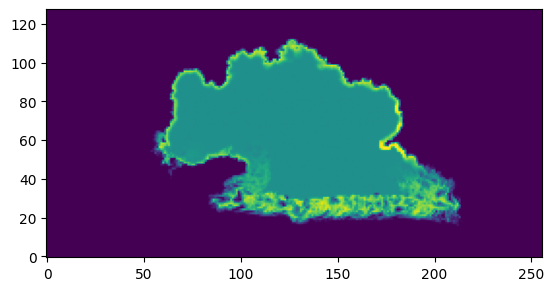

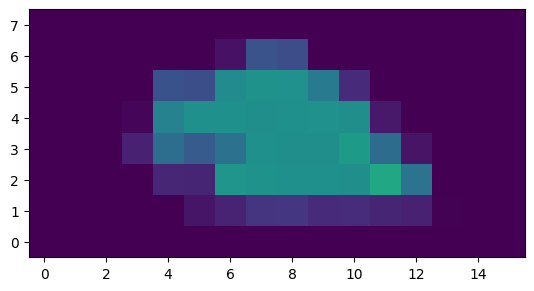

In [2]:
import matplotlib.pyplot as plt

plt.imshow(ref_grid.cpu()[:,:,ref_grid.shape[2]//2].transpose(0,1), vmin=0.0, vmax=0.6)
plt.gca().invert_yaxis()
plt.show()
plt.imshow(coarse_grid.cpu()[:,:,coarse_grid.shape[2]//2].transpose(0,1), vmin=0.0, vmax=0.6)
plt.gca().invert_yaxis()
plt.show()

In [3]:
grid = pipeline.sample_volume(
    resolution=256,
    decoding_resolution=128,
    samples=200,
    scheduler_gamma=2.0,
    guiding_strength=1.0,
    y=coarse_grid,
    A=lambda v: coarser_grid(v, 3))

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


Posterior sampling DPS_DDIM: 100%|██████████| 190/190 [01:28<00:00,  2.15it/s]


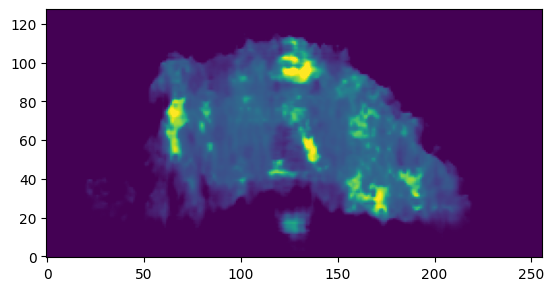

In [4]:
plt.imshow(grid.cpu()[:,:,grid.shape[2]//2].transpose(0,1), vmin=0.0, vmax=0.6)
plt.gca().invert_yaxis()
plt.show()

Rendering captures: 100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


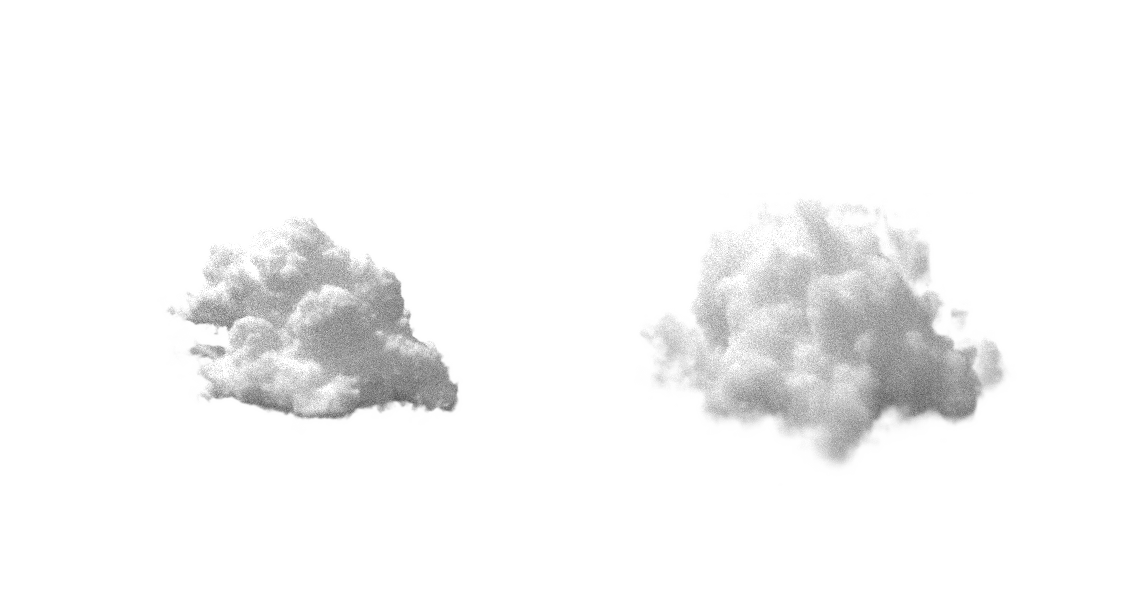

In [5]:
recorder.new_keyframe(recorder.add_capture_volume(grid, scattering_albedo=(0.999, 0.999, 0.999), samples=64))

recorder.show_clip(recorder.num_frames)